In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Import Training Data

In [3]:
df = pd.read_csv('preprocessed-data/2-label-training-data-preprocessed.csv')
df

,sentiment,tweet,Processed Text
0,-1,kita lanjutkan saja diam ini hingga kau dan ak...,lanjut diam hingga erti semua sama libat hati
1,1,doa rezeki tak putus inna haa zaa larizquna ma...,doa rezeki putus inna haa zaa larizquna maa la...
2,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...,terima kasih loh hasil sisa buat
3,-1,aku tak faham betul jenis orang malaysia yang ...,faham betul jenis malaysia tidak ret nak sangk...
4,-1,cerita dia macam ni mamat ni hari2 aku nampak ...,cerita macam mamat harihari tampak keluar masu...
...,...,...,...
5473,-1,Pelik tengok orang zaman sekarang ni dulu kema...,pelik jenguk zaman sekarang dulu main ria tunj...
5474,1,Jangan membandingkan kehidupanmu dengan kehidu...,jangan banding hidup hidup karena dari milik k...
5475,1,Apapun yg telah kamu lakukan apapun kesalahanm...,apa telah laku apa salah selalu temu kata maaf...
5476,1,3 cara untuk ingat semula apa yang kita dah ha...,cara ingat mula apa deh hafal


In [4]:
missing_data = df.isnull()
rows_with_missing = missing_data.any(axis=1)

# Filter the DataFrame to show only the rows with missing values
missing_rows = df[rows_with_missing]

# Display the rows with missing values
print("Rows with Missing Values:")
print(missing_rows)

Rows with Missing Values:
      sentiment         tweet Processed Text
487           1      ada aku             NaN
1035          1   aku aja aku            NaN
2126          1     dapet aku            NaN
2493          1      ada kamu            NaN
2527         -1    aku belum             NaN
2977          1  kamu jugaaa             NaN


In [5]:
# delete rows with missing values
df = df.dropna(subset=['Processed Text'])
df.isnull().sum()

sentiment         0
tweet             0
Processed Text    0
dtype: int64

# Splitting Data

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Processed Text'], df['sentiment'], test_size=0.2, random_state=42)

print("Train : ", X_train.shape, y_train.shape, "\nTest : ", X_test.shape, y_test.shape)

Train :  (4377,) (4377,) 
Test :  (1095,) (1095,)


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.4f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.4f" % precision_score(ytest, pred, average='macro'))
    print("Recall (Test Set): %.4f" % recall_score(ytest, pred, average='macro'))
    print("F1-Score (Test Set): %.4f" % f1_score(ytest, pred, average='macro'))

# TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

In [9]:
from sklearn.model_selection import cross_val_score

# cross validation
def cross_val(model, xtrain, ytrain, cv):
    scores = cross_val_score(model, xtrain, ytrain, cv=cv, scoring='accuracy')
    print("Cross Validation Scores:", scores)
    print("Cross Validation Mean Score: %.4f" % scores.mean())
    print("Cross Validation Standard Deviation: %.4f" % scores.std())

In [59]:
# Initializing model score dataframe
model_score = pd.DataFrame(columns=['model', 'cross validation accuracy', 'standard deviations', 'test accuracy'])

In [11]:
# Train and evaluate models using K-fold cross-validation
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

def evaluate(classifier, xtrain, ytrain, xtest, cv):
    # Compute cross-validated accuracy score
    cross_val_scores = cross_val_score(classifier, xtrain, ytrain, cv=cv, scoring='accuracy')

    # Print results
    print(f'Cross-validated accuracy score: {cross_val_scores.mean()}')

    # Print standard deviation
    print(f'Standard deviation: {cross_val_scores.std()}')

    # Fitting classifier to the Training set
    classifier.fit(xtrain, ytrain)

    # Predicting the Test set results
    y_pred = classifier.predict(xtest)

    # Making the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # Adding model score to dataframe
    model_score.loc[len(model_score)] = [classifier.__class__.__name__, cross_val_scores.mean(), cross_val_scores.std(), accuracy]

## Model 1: SVM

In [60]:
from sklearn.svm import SVC

svm = SVC()
evaluate(svm, tf_x_train, y_train, tf_x_test, 5)

Cross-validated accuracy score: 0.7363509458577953
Standard deviation: 0.015643256164820443
[[476 113]
 [181 325]]
Accuracy: 0.7315068493150685


In [61]:
svm_pred = svm.predict(tf_x_test)
print(classification_report(y_test, svm_pred))
eval_classification(svm, svm_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.72      0.81      0.76       589
           1       0.74      0.64      0.69       506

    accuracy                           0.73      1095
   macro avg       0.73      0.73      0.73      1095
weighted avg       0.73      0.73      0.73      1095

Accuracy (Test Set): 0.7315
Precision (Test Set): 0.7333
Recall (Test Set): 0.7252
F1-Score (Test Set): 0.7263


In [14]:
svm_param = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4, 5]
}

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=svm_param,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [15]:
grid_svm.fit(tf_x_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [16]:
grid_svm_pred = grid_svm.predict(tf_x_test)
print(classification_report(y_test, grid_svm_pred))
eval_classification(grid_svm, grid_svm_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.72      0.81      0.76       589
           1       0.74      0.64      0.69       506

    accuracy                           0.73      1095
   macro avg       0.73      0.73      0.73      1095
weighted avg       0.73      0.73      0.73      1095

Accuracy (Test Set): 0.7315
Precision (Test Set): 0.7333
Recall (Test Set): 0.7252
F1-Score (Test Set): 0.7263


## Model 2: KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
evaluate(knn, tf_x_train, y_train, tf_x_test, 5)

Cross-validated accuracy score: 0.672379125896934
Standard deviation: 0.016519206418885633
[[401 188]
 [148 358]]
Accuracy: 0.6931506849315069


In [63]:
knn_pred = knn.predict(tf_x_test)
print(classification_report(y_test, knn_pred))
eval_classification(knn, knn_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.73      0.68      0.70       589
           1       0.66      0.71      0.68       506

    accuracy                           0.69      1095
   macro avg       0.69      0.69      0.69      1095
weighted avg       0.70      0.69      0.69      1095

Accuracy (Test Set): 0.6932
Precision (Test Set): 0.6930
Recall (Test Set): 0.6942
F1-Score (Test Set): 0.6927


In [19]:
knn_params = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=knn_params,
    cv=5,
    verbose=1,
    n_jobs=-1
)

In [20]:
grid_knn.fit(tf_x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [5, 10, 15, 20],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [21]:
grid_knn_pred = grid_knn.predict(tf_x_test)
print(classification_report(y_test, grid_knn_pred))
eval_classification(grid_knn, grid_knn_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.74      0.67      0.70       589
           1       0.65      0.72      0.68       506

    accuracy                           0.69      1095
   macro avg       0.69      0.70      0.69      1095
weighted avg       0.70      0.69      0.69      1095

Accuracy (Test Set): 0.6941
Precision (Test Set): 0.6948
Recall (Test Set): 0.6958
F1-Score (Test Set): 0.6938


## Model 3: Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
evaluate(dt, tf_x_train, y_train, tf_x_test, 5)

Cross-validated accuracy score: 0.6657518590998043
Standard deviation: 0.00982348541653699
[[416 173]
 [194 312]]
Accuracy: 0.6648401826484018


In [65]:
dt_pred = dt.predict(tf_x_test)
print(classification_report(y_test, dt_pred))
eval_classification(dt, dt_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.68      0.71      0.69       589
           1       0.64      0.62      0.63       506

    accuracy                           0.66      1095
   macro avg       0.66      0.66      0.66      1095
weighted avg       0.66      0.66      0.66      1095

Accuracy (Test Set): 0.6648
Precision (Test Set): 0.6626
Recall (Test Set): 0.6614
F1-Score (Test Set): 0.6618


## Model 4: Naive Bayes

In [66]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
evaluate(nb, tf_x_train, y_train, tf_x_test, 5)

Cross-validated accuracy score: 0.7308667971298108
Standard deviation: 0.014592234254958909
[[495  94]
 [187 319]]
Accuracy: 0.7433789954337899


In [67]:
nb_pred = nb.predict(tf_x_test)
print(classification_report(y_test, nb_pred))
eval_classification(nb, nb_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.73      0.84      0.78       589
           1       0.77      0.63      0.69       506

    accuracy                           0.74      1095
   macro avg       0.75      0.74      0.74      1095
weighted avg       0.75      0.74      0.74      1095

Accuracy (Test Set): 0.7434
Precision (Test Set): 0.7491
Recall (Test Set): 0.7354
F1-Score (Test Set): 0.7366


## Model 5: Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
evaluate(rf, tf_x_train, y_train, tf_x_test, 5)

Cross-validated accuracy score: 0.7196714938030007
Standard deviation: 0.011519958818980092
[[465 124]
 [166 340]]
Accuracy: 0.7351598173515982


In [145]:
rf_pred = rf.predict(tf_x_test)
print(classification_report(y_test, rf_pred))
eval_classification(rf, rf_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.74      0.79      0.76       589
           1       0.73      0.67      0.70       506

    accuracy                           0.74      1095
   macro avg       0.73      0.73      0.73      1095
weighted avg       0.73      0.74      0.73      1095

Accuracy (Test Set): 0.7352
Precision (Test Set): 0.7348
Recall (Test Set): 0.7307
F1-Score (Test Set): 0.7317


## Model 6: Voting-Hard

In [69]:
estimators = [
    ('svm', svm),
    ('knn', knn),
    ('dt', dt),
    ('nb', nb)
]

In [70]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier

voting_hard = VotingClassifier(estimators=estimators, voting='hard')
evaluate(voting_hard, tf_x_train, y_train, tf_x_test, 5)

Cross-validated accuracy score: 0.7310974559686889
Standard deviation: 0.013527820196302233
[[502  87]
 [204 302]]
Accuracy: 0.7342465753424657


In [71]:
voting_hard_pred = voting_hard.predict(tf_x_test)
print(classification_report(y_test, voting_hard_pred))
eval_classification(voting_hard, voting_hard_pred, tf_x_train, y_train, tf_x_test, y_test)

              precision    recall  f1-score   support

          -1       0.71      0.85      0.78       589
           1       0.78      0.60      0.67       506

    accuracy                           0.73      1095
   macro avg       0.74      0.72      0.73      1095
weighted avg       0.74      0.73      0.73      1095

Accuracy (Test Set): 0.7342
Precision (Test Set): 0.7437
Recall (Test Set): 0.7246
F1-Score (Test Set): 0.7251


# Evaluasi

In [72]:
model_score.sort_values(by='test accuracy', ascending=False)

,model,cross validation accuracy,standard deviations,test accuracy
3,MultinomialNB,0.730867,0.014592,0.743379
4,RandomForestClassifier,0.719671,0.011520,0.735160
5,VotingClassifier,0.731097,0.013528,0.734247
0,SVC,0.736351,0.015643,0.731507
1,KNeighborsClassifier,0.672379,0.016519,0.693151
2,DecisionTreeClassifier,0.665752,0.009823,0.664840


In [144]:
# save model
import pickle

best_model = rf
filename = 'model2.sav'
pickle.dump(best_model, open(filename, 'wb'))

# Testing

In [135]:
model = pickle.load(open('model.sav', 'rb'))

In [37]:
def predict(model, df_test):
    # Scale the data

    # Predict the label
    label = model.predict(df_test)

    # Define the dictionary of labels
    labels = {
        -1 : "Negatif",
        1: "Positif",
    }

    # Return the label
    return labels[label[0]]

## Pra Kejadian

https://twitter.com/ardhitoprmn/status/1295000749831684096?t=wwrmFL9K9J76jGum3nzIDA&s=19

In [38]:
pra_kejadian = pd.read_csv('preprocessed-data\cp_preprocessed_pra.csv')
pra_kejadian.isnull().values.sum()

0

In [39]:
tf_pra_kejadian = vectorizer.transform(pra_kejadian['Processed Text'])
pra_kejadian['sentiment'] = [predict(rf, tf_pra_kejadian[i]) for i in range(len(pra_kejadian['tweet']))]

# show tweet and sentiment column
pra_kejadian[['tweet', 'sentiment']]

,tweet,sentiment
0,Akhirnya bisa nonton bang ardhito manggung lagi,Positif
1,Wooww aku blm pernah nonton ardhito,Negatif
2,that's my baby,Positif
3,Akhirnya bisa ngrasain suasana gigs lagi setel...,Negatif
4,Akhirnya bisa nonton ardhito manggung,Positif
...,...,...
90,Keren banget sumpah. Sepanjang konser ikutan n...,Positif
91,Apa kabar omnibuslaw bung? Merdeka!!,Negatif
92,mantapppp,Positif
93,Kapan dito,Negatif


## Pra Kejadian 2

https://twitter.com/ardhitoprmn/status/1295000749831684096?t=wwrmFL9K9J76jGum3nzIDA&s=19

In [76]:
pra_kejadian2 = pd.read_csv('preprocessed-data\preprocessed-tweet-pra-kejadian.csv')
pra_kejadian2.isnull().values.sum()

0

In [106]:
tf_pra_kejadian2 = vectorizer.transform(pra_kejadian2['Processed Text'])
pra_kejadian2['sentiment'] = [predict(rf, tf_pra_kejadian2[i]) for i in range(len(pra_kejadian2['tweet']))]

# show tweet and sentiment column
pra_kejadian2[['tweet', 'sentiment']]

,tweet,sentiment
0,komen,Positif
1,"Nah gini dari pada lo cuma balesin tweet gue, ...",Negatif
2,iya iya,Positif
3,This is awesome :),Negatif
4,Sini bagi bahagianya,Positif
...,...,...
82,~~ iklan yaa kak,Positif
83,izin numpang jualan kak,Positif
84,"halooo, aku jual netflix viu dll yuk dm langsu...",Negatif
85,"""",Positif


## Pasca Kejadian

https://twitter.com/AREAJULID/status/1481583097036816390?t=5jPSjPehO5vEo5abjSCp5g&s=19

In [110]:
pasca_kejadian = pd.read_csv('preprocessed-data\preprocessed-tweet-pasca-kejadian.csv')
pasca_kejadian.isnull().values.sum()

0

In [142]:
tf_pasca_kejadian = vectorizer.transform(pasca_kejadian['Processed Text'])
pasca_kejadian['sentiment'] = [predict(rf, tf_pasca_kejadian[i]) for i in range(len(pasca_kejadian['tweet']))]

# show tweet and sentiment column
pasca_kejadian[['tweet', 'sentiment']]

,tweet,sentiment
0,Iyaa lagi:),Positif
1,aku yang tidak peduli,Negatif
2,RUMOR DI TWT KATANYA UDH PUNYA ANAK JUGAAA,Negatif
3,"""Berdiam terlihat jomblo,",Negatif
4,"Bergerak bikin melongo """,Positif
...,...,...
150,"1. Korean midi dress 119k """,Negatif
151,Yg cari alumunium foil nih murah meriah free o...,Positif
152,twitter pls do your magic! telor dadar ini dij...,Negatif
153,Ardito gak suka camping si. Kalo demen kan gak...,Negatif


## Pasca Kejadian 2

https://twitter.com/mazzini_gsp/status/1482352824763949056?t=gh3jW7diN9FIAamvpm2CMw&s=19

In [118]:
pasca_kejadian2 = pd.read_csv('preprocessed-data\cp4_revised_preprocessed_pasca.csv')
pasca_kejadian2.isnull().values.sum()

0

In [119]:
# drop rows with missing values
pasca_kejadian2 = pasca_kejadian2.dropna(subset=['Processed Text'])
pasca_kejadian2.isnull().values.sum()

0

In [138]:
tf_pasca_kejadian2 = vectorizer.transform(pasca_kejadian2['Processed Text'])
pasca_kejadian2['sentiment'] = [predict(rf, tf_pasca_kejadian2[i]) for i in range(len(pasca_kejadian2['tweet']))]

# show tweet and sentiment column
pasca_kejadian2[['tweet', 'sentiment']]

,tweet,sentiment
0,"""Ini hasil dari pengembangan kasus dan laporan...",Negatif
1,"Bisa jadi sih, atau cepu tadi ya.",Positif
2,Klo nggak di list mungkun FF juga udh ditangka...,Negatif
3,polisi nyambi jd temen artis kan juga banyak bang,Positif
4,Di bandar nya ada cepu bang.,Negatif
...,...,...
188,sbner nya data nya udah ada.. trus masa pengi...,Positif
189,biasa nya ini ulah bede nya jga..,Negatif
190,udh rahasia umum...polisi mah udh pegang nama ...,Positif
191,percaya sama polisi? hahahahahaha,Positif


## Export Data to CSV

In [146]:
# export to csv
pra_kejadian.to_csv('sentimented-tweet-pra-kejadian.csv', index=False)
pra_kejadian2.to_csv('sentimented-tweet-pra-kejadian2.csv', index=False)
pasca_kejadian.to_csv('sentimented-tweet-pasca-kejadian.csv', index=False)
pasca_kejadian2.to_csv('sentimented-tweet-pasca-kejadian2.csv', index=False)

# Visualisasi

In [130]:
pra_kejadian['sentiment'].value_counts()

Positif    74
Negatif    21
Name: sentiment, dtype: int64

In [108]:
pra_kejadian2['sentiment'].value_counts()

Positif    59
Negatif    28
Name: sentiment, dtype: int64

In [143]:
pasca_kejadian['sentiment'].value_counts()

Negatif    95
Positif    60
Name: sentiment, dtype: int64

In [139]:
pasca_kejadian2['sentiment'].value_counts()

Negatif    125
Positif     68
Name: sentiment, dtype: int64

In [107]:
import matplotlib.pyplot as plt

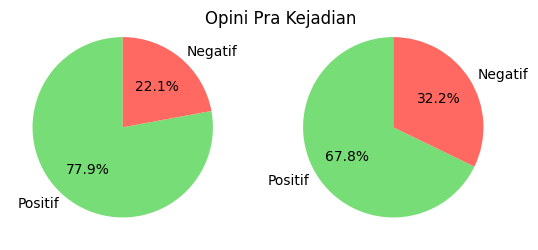

In [109]:
# pie chart visualization on pra kejadian
plt.subplot(1, 2, 1)
labels = ['Positif', 'Negatif']
sizes = [pra_kejadian['sentiment'].value_counts()[0], pra_kejadian['sentiment'].value_counts()[1]]
colors = ['#77DD76', '#FF6962']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)


plt.subplot(1, 2, 2)
sizes2 = [pra_kejadian2['sentiment'].value_counts()[0], pra_kejadian2['sentiment'].value_counts()[1]]
plt.pie(sizes2, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Opini Pra Kejadian', y=0.925, x=0)

plt.show()

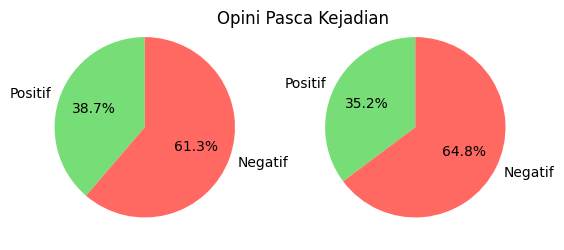

In [122]:
# pie chart visualization on pasca kejadian
plt.subplot(1, 2, 1)
labels = ['Positif', 'Negatif']
sizes = [pasca_kejadian['sentiment'].value_counts()[1], pasca_kejadian['sentiment'].value_counts()[0]]
colors = ['#77DD76', '#FF6962']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

plt.subplot(1, 2, 2)
sizes2 = [pasca_kejadian2['sentiment'].value_counts()[1], pasca_kejadian2['sentiment'].value_counts()[0]]
plt.pie(sizes2, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Opini Pasca Kejadian', y=0.925, x=0)

plt.show()

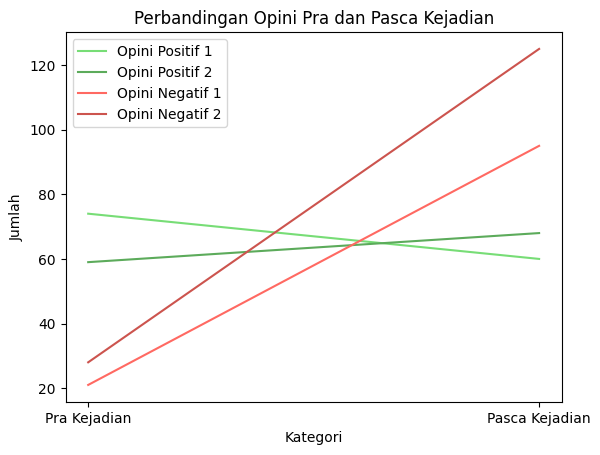

In [133]:
# Line Chart
x = ['Pra Kejadian', 'Pasca Kejadian']
y = [pra_kejadian['sentiment'].value_counts()[0], pasca_kejadian['sentiment'].value_counts()[1]]
y2 = [pra_kejadian['sentiment'].value_counts()[1], pasca_kejadian['sentiment'].value_counts()[0]]
y3 = [pra_kejadian2['sentiment'].value_counts()[0], pasca_kejadian2['sentiment'].value_counts()[1]]
y4 = [pra_kejadian2['sentiment'].value_counts()[1], pasca_kejadian2['sentiment'].value_counts()[0]]
plt.plot(x, y, label='Opini Positif 1', color='#77DD76')
plt.plot(x, y3, label='Opini Positif 2', color='#5CAB5B')
plt.plot(x, y2, label='Opini Negatif 1', color='#FF6962')
plt.plot(x, y4, label='Opini Negatif 2', color='#CC544E')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.title('Perbandingan Opini Pra dan Pasca Kejadian')
plt.legend()

In [55]:
def bar_chart(df, df2):
    categories = ['Pra Kejadian', 'Pasca Kejadian']
    
    positive_before = df[df['sentiment'] == 'Positif']['sentiment'].count()
    positive_after = df2[df2['sentiment'] == 'Positif']['sentiment'].count()
    
    negative_before = df[df['sentiment'] == 'Negatif']['sentiment'].count()
    negative_after = df2[df2['sentiment'] == 'Negatif']['sentiment'].count()
    
    positive_opinions = [positive_before, positive_after]
    negative_opinions = [negative_before, negative_after]
    
    bar_width = 0.35
    opacity = 0.8
    
    plt.bar(categories, positive_opinions, bar_width, alpha=opacity, label='Opini Positif', align='center', color='#77DD76')
    plt.bar(categories, negative_opinions, bar_width, alpha=opacity, label='Opini Negatif', align='edge', color='#FF6962')
    
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah')
    plt.title('Perbandingan Opini Positif dan Negatif Pra dan Pasca Kejadian')
    plt.legend()
    
    plt.show()

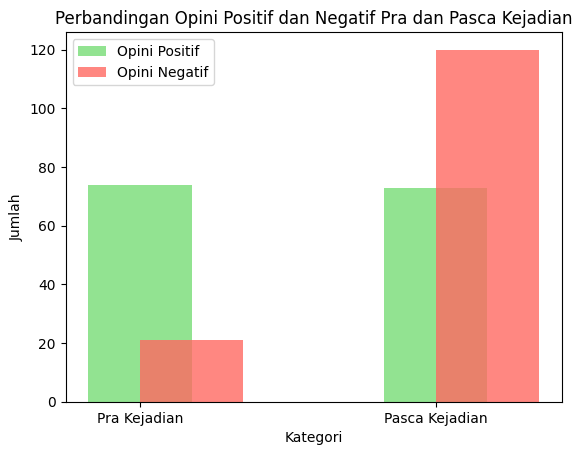

In [56]:
bar_chart(pra_kejadian, pasca_kejadian)

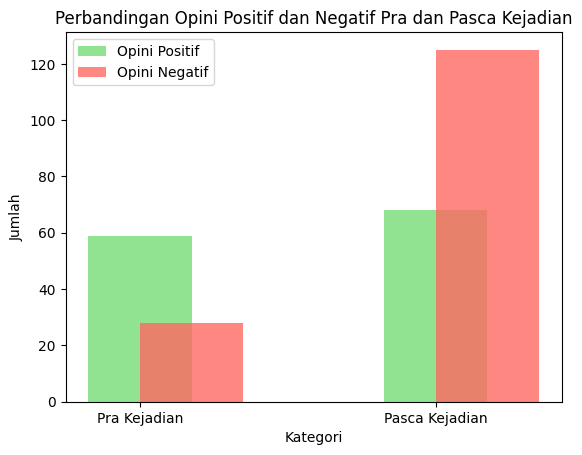

In [134]:
bar_chart(pra_kejadian2, pasca_kejadian2)